In [1]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import PIL
from random import shuffle
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
import pickle

In [3]:
with open('dataconvall.pt', 'rb') as f:
    data = pickle.load(f)
    
with open('labelsall.pt', 'rb') as f:
    labels = pickle.load(f)
    
with open('datavalconvall.pt', 'rb') as f:
    dataVal = pickle.load(f)
    
with open('labelsval.pt', 'rb') as f:
    labelsVal = pickle.load(f)

In [4]:
class PonceNet(nn.Module):

    def __init__(self,dropout=0.5):
        super(PonceNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3,padding=1)
        self.conv12 = nn.Conv2d(20, 20, kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(20, 30, kernel_size=3,padding=1)
        self.conv22 = nn.Conv2d(30, 30, kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(30, 40, kernel_size=3,padding=1)
        self.conv32 = nn.Conv2d(40, 40, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(40, 50, kernel_size=3,padding=1)
        self.conv42 = nn.Conv2d(50, 50, kernel_size=3,padding=1)
        self.ds1 = nn.Conv2d(3,20,kernel_size=1)
        self.ds2 = nn.Conv2d(20,30,kernel_size=1)
        self.ds3 = nn.Conv2d(30,40,kernel_size=1)
        self.ds4 = nn.Conv2d(40,50,kernel_size=1)
        self.mp = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(20)
        self.bn2 = nn.BatchNorm2d(30)
        self.bn3 = nn.BatchNorm2d(40)
        self.bn4 = nn.BatchNorm2d(50)
        self.fc1 = nn.Linear(3000,200)
        self.fc2 = nn.Linear(200, 4)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        in_size = x.size(0)
        x = self.mp(x)
        x = self.mp(x)
        y = x
        x = self.dropout(torch.relu(self.bn1(self.conv1(x))))
        x = self.dropout(self.bn1(self.conv12(x)))
        y = self.ds1(y)
        x += y
        x = torch.relu(x)
        x = self.mp(x)
        y = x
        x = self.dropout(torch.relu(self.bn2(self.conv2(x))))
        x = self.dropout(self.bn2(self.conv22(x)))
        y = self.ds2(y)
        x += y
        x = torch.relu(x)
        x = self.mp(x)
        y = x
        x = self.dropout(torch.relu(self.bn3(self.conv3(x))))
        x = self.dropout(self.bn3(self.conv32(x)))
        y = self.ds3(y)
        x += y
        x = torch.relu(x)
        x = self.mp(x)
        y = x
        x = self.dropout(torch.relu(self.bn4(self.conv4(x))))
        x = self.dropout(self.bn4(self.conv42(x)))
        y = self.ds4(y)
        x += y
        x = torch.relu(x)
        x = self.mp(x)
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return torch.log_softmax(x,1)


In [5]:
class AutoUXDataset(Dataset):
    def __init__(self, data, labels,isTrain=True,isVal=False):
        self.data = data
        self.labels = labels
        self.isTrain = isTrain
        self.isVal = isVal
        if isVal:
            self.testX = torch.from_numpy(np.asarray(data,dtype=np.uint8)).type('torch.FloatTensor')
            self.testY = torch.from_numpy(np.asarray(labels,dtype=np.uint8)).type('torch.LongTensor')
        else:
            self.setTest(0)

    def __len__(self):
        if self.isTrain:
            return len(self.trainX)
        else:
            return len(self.testX)

    def setTest(self,testI):
        if self.isVal:
            return
        d = np.empty((0,3,384,683),int)
        l = []
        for i in range(5):
            if i != testI:
                d = np.append(d,data[i],axis=0)
                l += labels[i]
            else:
                self.testX = torch.from_numpy(np.asarray(data[i],dtype=np.uint8)).type('torch.FloatTensor')
                self.testY = torch.from_numpy(np.asarray(labels[i],dtype=np.uint8)).type('torch.LongTensor')
                
        self.trainX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
        self.trainY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
    
    def __getitem__(self, idx):
        if self.isTrain:
            return {"img" : self.trainX[idx], "label": self.trainY[idx]}
        else:
            return {"img" : self.testX[idx], "label": self.testY[idx]}

In [7]:
def train_batch(model,crit,opt,x, y):
    opt.zero_grad()
    y_pred = model(x)
    loss = crit(y_pred, y)
    loss.backward()
    opt.step() 
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def train(model,crit,opt,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    for s in tqdm(dataload,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        lo, acc = train_batch(model,crit,opt,x,y)
        dloss += lo
        dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

def test_batch(model,crit,scheduler,x, y):
    y_pred = model(x)
    loss = crit(y_pred, y)
#     scheduler.step(loss)
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def test(model,crit,scheduler,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    with torch.no_grad():
        for s in tqdm(dataload,disable=disable):
            x, y = s.values()
            x = x.cuda()
            y = y.cuda()
            lo, acc = test_batch(model,crit,scheduler,x,y)
            dloss += lo
            dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.51it/s]


Epoch Train Loss: 0.877921  Epoch Train Accuracy: 48.943015  Epoch Test Loss: 0.834205  Epoch Test Accuracy: 45.018939


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.63it/s]


Epoch Train Loss: 0.739634  Epoch Train Accuracy: 51.907169  Epoch Test Loss: 0.733743  Epoch Test Accuracy: 50.217803


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.82it/s]


Epoch Train Loss: 0.714985  Epoch Train Accuracy: 54.120711  Epoch Test Loss: 0.735622  Epoch Test Accuracy: 51.600379


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.77it/s]


Epoch Train Loss: 0.708689  Epoch Train Accuracy: 52.882455  Epoch Test Loss: 0.728671  Epoch Test Accuracy: 49.090909


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.57it/s]


Epoch Train Loss: 0.687267  Epoch Train Accuracy: 57.248264  Epoch Test Loss: 0.714697  Epoch Test Accuracy: 52.386364


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.15it/s]


Epoch Train Loss: 0.678640  Epoch Train Accuracy: 56.724877  Epoch Test Loss: 0.754228  Epoch Test Accuracy: 49.441288


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.06it/s]


Epoch Train Loss: 0.669838  Epoch Train Accuracy: 57.929943  Epoch Test Loss: 0.759421  Epoch Test Accuracy: 41.628788


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.16it/s]


Epoch Train Loss: 0.663895  Epoch Train Accuracy: 59.459252  Epoch Test Loss: 0.735879  Epoch Test Accuracy: 54.384470


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.65it/s]


Epoch Train Loss: 0.649103  Epoch Train Accuracy: 65.127145  Epoch Test Loss: 0.770120  Epoch Test Accuracy: 48.219697


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.78it/s]


Epoch Train Loss: 0.633482  Epoch Train Accuracy: 63.564645  Epoch Test Loss: 0.804148  Epoch Test Accuracy: 45.359848


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.00it/s]


Epoch Train Loss: 0.611714  Epoch Train Accuracy: 65.681168  Epoch Test Loss: 0.763666  Epoch Test Accuracy: 51.515152


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.85it/s]


Epoch Train Loss: 0.612248  Epoch Train Accuracy: 67.343239  Epoch Test Loss: 0.747760  Epoch Test Accuracy: 50.388258


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.64it/s]


Epoch Train Loss: 0.589892  Epoch Train Accuracy: 67.830882  Epoch Test Loss: 0.825253  Epoch Test Accuracy: 44.924242


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.53it/s]


Epoch Train Loss: 0.592310  Epoch Train Accuracy: 67.828329  Epoch Test Loss: 0.800635  Epoch Test Accuracy: 50.558712


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.55it/s]


Epoch Train Loss: 0.604744  Epoch Train Accuracy: 67.634293  Epoch Test Loss: 0.775245  Epoch Test Accuracy: 49.337121


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.59it/s]


Epoch Train Loss: 0.585252  Epoch Train Accuracy: 69.360192  Epoch Test Loss: 0.833120  Epoch Test Accuracy: 48.816288


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.84it/s]


Epoch Train Loss: 0.584513  Epoch Train Accuracy: 67.498979  Epoch Test Loss: 0.780423  Epoch Test Accuracy: 57.594697


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.89it/s]


Epoch Train Loss: 0.582887  Epoch Train Accuracy: 68.315972  Epoch Test Loss: 0.835759  Epoch Test Accuracy: 46.571970


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.81it/s]


Epoch Train Loss: 0.579534  Epoch Train Accuracy: 69.196793  Epoch Test Loss: 0.813945  Epoch Test Accuracy: 46.231061


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.98it/s]


Epoch Train Loss: 0.547660  Epoch Train Accuracy: 73.230699  Epoch Test Loss: 0.787952  Epoch Test Accuracy: 54.554924


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.80it/s]


Epoch Train Loss: 0.544966  Epoch Train Accuracy: 70.432496  Epoch Test Loss: 0.810207  Epoch Test Accuracy: 54.128788


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.68it/s]


Epoch Train Loss: 0.539633  Epoch Train Accuracy: 73.069853  Epoch Test Loss: 0.866405  Epoch Test Accuracy: 47.623106


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.08it/s]


Epoch Train Loss: 0.542836  Epoch Train Accuracy: 71.310764  Epoch Test Loss: 0.787977  Epoch Test Accuracy: 55.596591


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.61it/s]


Epoch Train Loss: 0.526932  Epoch Train Accuracy: 73.588133  Epoch Test Loss: 0.843874  Epoch Test Accuracy: 49.261364


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.75it/s]


Epoch Train Loss: 0.529749  Epoch Train Accuracy: 73.169424  Epoch Test Loss: 0.811994  Epoch Test Accuracy: 50.047348


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.74it/s]


Epoch Train Loss: 0.528282  Epoch Train Accuracy: 72.584763  Epoch Test Loss: 0.837286  Epoch Test Accuracy: 55.767045


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.88it/s]


Epoch Train Loss: 0.527712  Epoch Train Accuracy: 74.731924  Epoch Test Loss: 0.829427  Epoch Test Accuracy: 54.204545


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.74it/s]


Epoch Train Loss: 0.498310  Epoch Train Accuracy: 75.446793  Epoch Test Loss: 0.781818  Epoch Test Accuracy: 56.638258


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.77it/s]


Epoch Train Loss: 0.477103  Epoch Train Accuracy: 76.687602  Epoch Test Loss: 0.828482  Epoch Test Accuracy: 50.994318


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.36it/s]


Epoch Train Loss: 0.482541  Epoch Train Accuracy: 75.577002  Epoch Test Loss: 0.790199  Epoch Test Accuracy: 57.670455


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.78it/s]


Epoch Train Loss: 0.472804  Epoch Train Accuracy: 77.989685  Epoch Test Loss: 0.786738  Epoch Test Accuracy: 53.598485


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.90it/s]


Epoch Train Loss: 0.467144  Epoch Train Accuracy: 78.117341  Epoch Test Loss: 0.838534  Epoch Test Accuracy: 54.990530


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.56it/s]


Epoch Train Loss: 0.458631  Epoch Train Accuracy: 77.757353  Epoch Test Loss: 0.760584  Epoch Test Accuracy: 54.204545


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.58it/s]


Epoch Train Loss: 0.449278  Epoch Train Accuracy: 80.333435  Epoch Test Loss: 0.906352  Epoch Test Accuracy: 46.742424


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.97it/s]


Epoch Train Loss: 0.438368  Epoch Train Accuracy: 79.485805  Epoch Test Loss: 0.789518  Epoch Test Accuracy: 58.541667


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.90it/s]


Epoch Train Loss: 0.439676  Epoch Train Accuracy: 80.328329  Epoch Test Loss: 0.894922  Epoch Test Accuracy: 53.342803


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.64it/s]


Epoch Train Loss: 0.403862  Epoch Train Accuracy: 81.408292  Epoch Test Loss: 0.900930  Epoch Test Accuracy: 50.047348


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.03it/s]


Epoch Train Loss: 0.404790  Epoch Train Accuracy: 80.397263  Epoch Test Loss: 0.845427  Epoch Test Accuracy: 55.596591


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.01it/s]


Epoch Train Loss: 0.421681  Epoch Train Accuracy: 80.849163  Epoch Test Loss: 0.871809  Epoch Test Accuracy: 58.456439


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.91it/s]


Epoch Train Loss: 0.409641  Epoch Train Accuracy: 80.328329  Epoch Test Loss: 0.838376  Epoch Test Accuracy: 55.672348


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.03it/s]


Epoch Train Loss: 0.348264  Epoch Train Accuracy: 84.923917  Epoch Test Loss: 0.904325  Epoch Test Accuracy: 54.119318


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.98it/s]


Epoch Train Loss: 0.326607  Epoch Train Accuracy: 84.987745  Epoch Test Loss: 0.898361  Epoch Test Accuracy: 58.371212


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.65it/s]


Epoch Train Loss: 0.322299  Epoch Train Accuracy: 86.583435  Epoch Test Loss: 0.918672  Epoch Test Accuracy: 57.670455


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.52it/s]


Epoch Train Loss: 0.330195  Epoch Train Accuracy: 85.868566  Epoch Test Loss: 0.848249  Epoch Test Accuracy: 57.850379


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.71it/s]


Epoch Train Loss: 0.354690  Epoch Train Accuracy: 82.807394  Epoch Test Loss: 0.892395  Epoch Test Accuracy: 55.501894


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.89it/s]


Epoch Train Loss: 0.325993  Epoch Train Accuracy: 85.056679  Epoch Test Loss: 0.943927  Epoch Test Accuracy: 52.736742


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.54it/s]


Epoch Train Loss: 0.309648  Epoch Train Accuracy: 86.289828  Epoch Test Loss: 0.853954  Epoch Test Accuracy: 59.583333


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.00it/s]


Epoch Train Loss: 0.304587  Epoch Train Accuracy: 87.791054  Epoch Test Loss: 0.881522  Epoch Test Accuracy: 56.467803


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.04it/s]


Epoch Train Loss: 0.289149  Epoch Train Accuracy: 87.168096  Epoch Test Loss: 0.962746  Epoch Test Accuracy: 58.285985


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.99it/s]


Epoch Train Loss: 0.289337  Epoch Train Accuracy: 88.018280  Epoch Test Loss: 0.934287  Epoch Test Accuracy: 58.806818
Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.54it/s]


Epoch Train Loss: 0.861942  Epoch Train Accuracy: 50.375306  Epoch Test Loss: 0.845389  Epoch Test Accuracy: 49.696970


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.98it/s]


Epoch Train Loss: 0.757022  Epoch Train Accuracy: 51.544628  Epoch Test Loss: 0.761557  Epoch Test Accuracy: 52.982955


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.83it/s]


Epoch Train Loss: 0.719030  Epoch Train Accuracy: 54.738562  Epoch Test Loss: 0.731793  Epoch Test Accuracy: 55.246212


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.97it/s]


Epoch Train Loss: 0.705343  Epoch Train Accuracy: 54.054330  Epoch Test Loss: 0.700246  Epoch Test Accuracy: 53.342803


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.05it/s]


Epoch Train Loss: 0.674604  Epoch Train Accuracy: 59.592014  Epoch Test Loss: 0.690265  Epoch Test Accuracy: 53.854167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.79it/s]


Epoch Train Loss: 0.651467  Epoch Train Accuracy: 61.805556  Epoch Test Loss: 0.690493  Epoch Test Accuracy: 56.202652


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.83it/s]


Epoch Train Loss: 0.658677  Epoch Train Accuracy: 60.957925  Epoch Test Loss: 0.686923  Epoch Test Accuracy: 57.594697


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.91it/s]


Epoch Train Loss: 0.654672  Epoch Train Accuracy: 61.575776  Epoch Test Loss: 0.672272  Epoch Test Accuracy: 60.625000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.67it/s]


Epoch Train Loss: 0.640832  Epoch Train Accuracy: 62.880413  Epoch Test Loss: 0.688139  Epoch Test Accuracy: 58.892045


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.78it/s]


Epoch Train Loss: 0.626790  Epoch Train Accuracy: 67.210478  Epoch Test Loss: 0.689107  Epoch Test Accuracy: 59.403409


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.82it/s]


Epoch Train Loss: 0.614029  Epoch Train Accuracy: 67.601103  Epoch Test Loss: 0.657447  Epoch Test Accuracy: 57.414773


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.80it/s]


Epoch Train Loss: 0.603738  Epoch Train Accuracy: 68.088746  Epoch Test Loss: 0.684393  Epoch Test Accuracy: 60.710227


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.97it/s]


Epoch Train Loss: 0.585552  Epoch Train Accuracy: 67.703227  Epoch Test Loss: 0.674746  Epoch Test Accuracy: 59.659091


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.94it/s]


Epoch Train Loss: 0.601278  Epoch Train Accuracy: 66.135621  Epoch Test Loss: 0.711459  Epoch Test Accuracy: 58.456439


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.87it/s]


Epoch Train Loss: 0.593249  Epoch Train Accuracy: 67.307496  Epoch Test Loss: 0.657810  Epoch Test Accuracy: 60.539773


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.85it/s]


Epoch Train Loss: 0.581113  Epoch Train Accuracy: 68.640217  Epoch Test Loss: 0.684563  Epoch Test Accuracy: 58.380682


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.82it/s]


Epoch Train Loss: 0.573906  Epoch Train Accuracy: 69.551675  Epoch Test Loss: 0.719968  Epoch Test Accuracy: 58.626894


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.71it/s]


Epoch Train Loss: 0.560457  Epoch Train Accuracy: 71.573734  Epoch Test Loss: 0.686392  Epoch Test Accuracy: 61.581439


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.43it/s]


Epoch Train Loss: 0.537901  Epoch Train Accuracy: 72.288603  Epoch Test Loss: 0.706378  Epoch Test Accuracy: 61.145833


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.83it/s]


Epoch Train Loss: 0.513958  Epoch Train Accuracy: 72.028186  Epoch Test Loss: 0.738105  Epoch Test Accuracy: 54.214015


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.60it/s]


Epoch Train Loss: 0.518958  Epoch Train Accuracy: 73.429841  Epoch Test Loss: 0.726641  Epoch Test Accuracy: 56.287879


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.81it/s]


Epoch Train Loss: 0.513786  Epoch Train Accuracy: 74.114073  Epoch Test Loss: 0.786275  Epoch Test Accuracy: 56.979167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.91it/s]


Epoch Train Loss: 0.505133  Epoch Train Accuracy: 74.502145  Epoch Test Loss: 0.721724  Epoch Test Accuracy: 54.119318


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.68it/s]


Epoch Train Loss: 0.508380  Epoch Train Accuracy: 75.742953  Epoch Test Loss: 0.774391  Epoch Test Accuracy: 56.373106


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.50it/s]


Epoch Train Loss: 0.494582  Epoch Train Accuracy: 76.031454  Epoch Test Loss: 0.726416  Epoch Test Accuracy: 53.077652


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.87it/s]


Epoch Train Loss: 0.480602  Epoch Train Accuracy: 76.294424  Epoch Test Loss: 0.718847  Epoch Test Accuracy: 61.837121


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.85it/s]


Epoch Train Loss: 0.483617  Epoch Train Accuracy: 76.457823  Epoch Test Loss: 0.723345  Epoch Test Accuracy: 57.585227


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.73it/s]


Epoch Train Loss: 0.469549  Epoch Train Accuracy: 77.175245  Epoch Test Loss: 0.758535  Epoch Test Accuracy: 57.765152


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.65it/s]


Epoch Train Loss: 0.465465  Epoch Train Accuracy: 76.588031  Epoch Test Loss: 0.753640  Epoch Test Accuracy: 56.714015


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.75it/s]


Epoch Train Loss: 0.462982  Epoch Train Accuracy: 77.139502  Epoch Test Loss: 0.746007  Epoch Test Accuracy: 57.594697


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.74it/s]


Epoch Train Loss: 0.432680  Epoch Train Accuracy: 77.108864  Epoch Test Loss: 0.779626  Epoch Test Accuracy: 61.316288


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.91it/s]


Epoch Train Loss: 0.443692  Epoch Train Accuracy: 77.269710  Epoch Test Loss: 0.749678  Epoch Test Accuracy: 59.412879


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.65it/s]


Epoch Train Loss: 0.482977  Epoch Train Accuracy: 75.676573  Epoch Test Loss: 0.818053  Epoch Test Accuracy: 53.854167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.89it/s]


Epoch Train Loss: 0.446177  Epoch Train Accuracy: 79.779412  Epoch Test Loss: 0.759506  Epoch Test Accuracy: 55.066288


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.03it/s]


Epoch Train Loss: 0.420333  Epoch Train Accuracy: 80.787888  Epoch Test Loss: 0.729429  Epoch Test Accuracy: 63.484848


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.86it/s]


Epoch Train Loss: 0.404219  Epoch Train Accuracy: 81.862745  Epoch Test Loss: 0.771111  Epoch Test Accuracy: 60.018939


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.93it/s]


Epoch Train Loss: 0.397102  Epoch Train Accuracy: 82.059334  Epoch Test Loss: 0.810295  Epoch Test Accuracy: 52.386364


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.84it/s]


Epoch Train Loss: 0.412751  Epoch Train Accuracy: 80.854269  Epoch Test Loss: 0.735122  Epoch Test Accuracy: 64.015152


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.82it/s]


Epoch Train Loss: 0.386596  Epoch Train Accuracy: 82.580167  Epoch Test Loss: 0.745975  Epoch Test Accuracy: 58.285985


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.60it/s]


Epoch Train Loss: 0.396777  Epoch Train Accuracy: 83.228656  Epoch Test Loss: 0.800220  Epoch Test Accuracy: 54.981061


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.89it/s]


Epoch Train Loss: 0.381321  Epoch Train Accuracy: 82.840584  Epoch Test Loss: 0.767170  Epoch Test Accuracy: 59.753788


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.29it/s]


Epoch Train Loss: 0.367308  Epoch Train Accuracy: 84.727328  Epoch Test Loss: 0.802285  Epoch Test Accuracy: 57.935606


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.74it/s]


Epoch Train Loss: 0.347668  Epoch Train Accuracy: 84.106924  Epoch Test Loss: 0.828829  Epoch Test Accuracy: 58.191288


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.57it/s]


Epoch Train Loss: 0.369703  Epoch Train Accuracy: 83.328227  Epoch Test Loss: 0.766338  Epoch Test Accuracy: 60.625000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.14it/s]


Epoch Train Loss: 0.354743  Epoch Train Accuracy: 85.411560  Epoch Test Loss: 0.830174  Epoch Test Accuracy: 61.145833


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.77it/s]


Epoch Train Loss: 0.352640  Epoch Train Accuracy: 84.826900  Epoch Test Loss: 0.890150  Epoch Test Accuracy: 55.416667


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.94it/s]


Epoch Train Loss: 0.374777  Epoch Train Accuracy: 84.009906  Epoch Test Loss: 0.800795  Epoch Test Accuracy: 54.905303


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.80it/s]


Epoch Train Loss: 0.331680  Epoch Train Accuracy: 85.414114  Epoch Test Loss: 0.829137  Epoch Test Accuracy: 58.892045


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.29it/s]


Epoch Train Loss: 0.342875  Epoch Train Accuracy: 85.023489  Epoch Test Loss: 0.880456  Epoch Test Accuracy: 56.638258


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.70it/s]


Epoch Train Loss: 0.335122  Epoch Train Accuracy: 86.386846  Epoch Test Loss: 0.811500  Epoch Test Accuracy: 58.977273
Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.62it/s]


Epoch Train Loss: 0.854667  Epoch Train Accuracy: 48.709754  Epoch Test Loss: 0.848646  Epoch Test Accuracy: 52.100134


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.01it/s]


Epoch Train Loss: 0.719976  Epoch Train Accuracy: 55.397727  Epoch Test Loss: 0.785602  Epoch Test Accuracy: 43.094758


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.81it/s]


Epoch Train Loss: 0.709283  Epoch Train Accuracy: 55.480587  Epoch Test Loss: 0.788282  Epoch Test Accuracy: 38.424059


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.69it/s]


Epoch Train Loss: 0.684786  Epoch Train Accuracy: 57.469223  Epoch Test Loss: 0.786259  Epoch Test Accuracy: 45.749328


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.69it/s]


Epoch Train Loss: 0.660858  Epoch Train Accuracy: 60.700758  Epoch Test Loss: 0.760094  Epoch Test Accuracy: 45.278898


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.85it/s]


Epoch Train Loss: 0.660804  Epoch Train Accuracy: 61.351799  Epoch Test Loss: 0.820989  Epoch Test Accuracy: 43.229167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.63it/s]


Epoch Train Loss: 0.644554  Epoch Train Accuracy: 63.008996  Epoch Test Loss: 0.812430  Epoch Test Accuracy: 39.499328


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.68it/s]


Epoch Train Loss: 0.657073  Epoch Train Accuracy: 60.712595  Epoch Test Loss: 0.761038  Epoch Test Accuracy: 45.816532


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.50it/s]


Epoch Train Loss: 0.637588  Epoch Train Accuracy: 62.677557  Epoch Test Loss: 0.776559  Epoch Test Accuracy: 47.429435


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.83it/s]


Epoch Train Loss: 0.646452  Epoch Train Accuracy: 59.280303  Epoch Test Loss: 0.734444  Epoch Test Accuracy: 49.462366


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.78it/s]


Epoch Train Loss: 0.653395  Epoch Train Accuracy: 59.872159  Epoch Test Loss: 0.738102  Epoch Test Accuracy: 48.504704


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.62it/s]


Epoch Train Loss: 0.608093  Epoch Train Accuracy: 67.021780  Epoch Test Loss: 0.757496  Epoch Test Accuracy: 58.484543


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.56it/s]


Epoch Train Loss: 0.624652  Epoch Train Accuracy: 64.535985  Epoch Test Loss: 0.686759  Epoch Test Accuracy: 54.200269


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.90it/s]


Epoch Train Loss: 0.595975  Epoch Train Accuracy: 67.720170  Epoch Test Loss: 0.694948  Epoch Test Accuracy: 61.088710


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.69it/s]


Epoch Train Loss: 0.586996  Epoch Train Accuracy: 69.034091  Epoch Test Loss: 0.722468  Epoch Test Accuracy: 55.729167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.80it/s]


Epoch Train Loss: 0.580261  Epoch Train Accuracy: 69.424716  Epoch Test Loss: 0.676669  Epoch Test Accuracy: 61.643145


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.70it/s]


Epoch Train Loss: 0.550815  Epoch Train Accuracy: 70.584754  Epoch Test Loss: 0.664999  Epoch Test Accuracy: 62.600806


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.40it/s]


Epoch Train Loss: 0.536272  Epoch Train Accuracy: 71.093750  Epoch Test Loss: 0.758161  Epoch Test Accuracy: 60.013441


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.82it/s]


Epoch Train Loss: 0.531259  Epoch Train Accuracy: 73.177083  Epoch Test Loss: 0.746891  Epoch Test Accuracy: 57.308468


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.27it/s]


Epoch Train Loss: 0.528465  Epoch Train Accuracy: 72.774621  Epoch Test Loss: 0.708758  Epoch Test Accuracy: 60.567876


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.25it/s]


Epoch Train Loss: 0.524508  Epoch Train Accuracy: 73.330966  Epoch Test Loss: 0.708558  Epoch Test Accuracy: 58.954973


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.03it/s]


Epoch Train Loss: 0.498247  Epoch Train Accuracy: 75.130208  Epoch Test Loss: 0.753298  Epoch Test Accuracy: 56.350806


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.42it/s]


Epoch Train Loss: 0.477371  Epoch Train Accuracy: 77.012311  Epoch Test Loss: 0.800749  Epoch Test Accuracy: 55.241935


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.57it/s]


Epoch Train Loss: 0.483425  Epoch Train Accuracy: 75.568182  Epoch Test Loss: 0.730009  Epoch Test Accuracy: 62.701613


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.51it/s]


Epoch Train Loss: 0.458015  Epoch Train Accuracy: 77.852746  Epoch Test Loss: 0.752699  Epoch Test Accuracy: 56.871640


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.34it/s]


Epoch Train Loss: 0.435368  Epoch Train Accuracy: 79.723011  Epoch Test Loss: 0.722458  Epoch Test Accuracy: 63.205645


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.76it/s]


Epoch Train Loss: 0.453746  Epoch Train Accuracy: 78.148674  Epoch Test Loss: 0.767975  Epoch Test Accuracy: 59.442204


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.57it/s]


Epoch Train Loss: 0.440276  Epoch Train Accuracy: 78.941761  Epoch Test Loss: 0.707996  Epoch Test Accuracy: 63.726478


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.51it/s]


Epoch Train Loss: 0.413549  Epoch Train Accuracy: 79.936080  Epoch Test Loss: 0.798343  Epoch Test Accuracy: 62.550403


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.24it/s]


Epoch Train Loss: 0.413344  Epoch Train Accuracy: 79.699337  Epoch Test Loss: 0.802466  Epoch Test Accuracy: 60.416667


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.26it/s]


Epoch Train Loss: 0.408728  Epoch Train Accuracy: 82.504735  Epoch Test Loss: 0.795829  Epoch Test Accuracy: 60.551075


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.20it/s]


Epoch Train Loss: 0.399947  Epoch Train Accuracy: 81.498580  Epoch Test Loss: 0.716837  Epoch Test Accuracy: 61.609543


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.55it/s]


Epoch Train Loss: 0.386960  Epoch Train Accuracy: 81.818182  Epoch Test Loss: 0.789095  Epoch Test Accuracy: 64.163306


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.49it/s]


Epoch Train Loss: 0.376576  Epoch Train Accuracy: 82.871686  Epoch Test Loss: 0.765557  Epoch Test Accuracy: 65.725806


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.66it/s]


Epoch Train Loss: 0.376474  Epoch Train Accuracy: 83.226799  Epoch Test Loss: 0.738107  Epoch Test Accuracy: 62.096774


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.65it/s]


Epoch Train Loss: 0.369632  Epoch Train Accuracy: 81.948390  Epoch Test Loss: 0.798077  Epoch Test Accuracy: 65.238575


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.45it/s]


Epoch Train Loss: 0.398173  Epoch Train Accuracy: 81.901042  Epoch Test Loss: 0.770527  Epoch Test Accuracy: 61.508737


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.58it/s]


Epoch Train Loss: 0.375348  Epoch Train Accuracy: 83.877841  Epoch Test Loss: 0.745622  Epoch Test Accuracy: 62.668011


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.04it/s]


Epoch Train Loss: 0.376204  Epoch Train Accuracy: 83.250473  Epoch Test Loss: 0.846207  Epoch Test Accuracy: 58.400538


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.27it/s]


Epoch Train Loss: 0.329147  Epoch Train Accuracy: 84.753788  Epoch Test Loss: 0.776910  Epoch Test Accuracy: 61.055108


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.64it/s]


Epoch Train Loss: 0.350367  Epoch Train Accuracy: 84.363163  Epoch Test Loss: 0.833589  Epoch Test Accuracy: 60.534274


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.50it/s]


Epoch Train Loss: 0.342460  Epoch Train Accuracy: 86.115057  Epoch Test Loss: 0.838552  Epoch Test Accuracy: 63.676075


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.81it/s]


Epoch Train Loss: 0.317247  Epoch Train Accuracy: 85.984848  Epoch Test Loss: 0.821879  Epoch Test Accuracy: 61.592742


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.63it/s]


Epoch Train Loss: 0.316956  Epoch Train Accuracy: 84.363163  Epoch Test Loss: 0.904371  Epoch Test Accuracy: 54.133065


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.72it/s]


Epoch Train Loss: 0.329087  Epoch Train Accuracy: 86.174242  Epoch Test Loss: 0.824402  Epoch Test Accuracy: 59.509409


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.79it/s]


Epoch Train Loss: 0.321908  Epoch Train Accuracy: 85.629735  Epoch Test Loss: 0.812206  Epoch Test Accuracy: 63.205645


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.73it/s]


Epoch Train Loss: 0.340193  Epoch Train Accuracy: 84.493371  Epoch Test Loss: 0.982157  Epoch Test Accuracy: 53.696237


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.69it/s]


Epoch Train Loss: 0.309279  Epoch Train Accuracy: 85.392992  Epoch Test Loss: 0.947062  Epoch Test Accuracy: 53.141801


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.56it/s]


Epoch Train Loss: 0.309119  Epoch Train Accuracy: 85.830966  Epoch Test Loss: 0.767604  Epoch Test Accuracy: 63.642473


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.67it/s]


Epoch Train Loss: 0.307271  Epoch Train Accuracy: 86.872633  Epoch Test Loss: 1.016954  Epoch Test Accuracy: 56.317204
Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.09it/s]


Epoch Train Loss: 0.861697  Epoch Train Accuracy: 49.064867  Epoch Test Loss: 0.792337  Epoch Test Accuracy: 49.042339


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.53it/s]


Epoch Train Loss: 0.756697  Epoch Train Accuracy: 50.047348  Epoch Test Loss: 0.713432  Epoch Test Accuracy: 53.057796


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.43it/s]


Epoch Train Loss: 0.724965  Epoch Train Accuracy: 51.633523  Epoch Test Loss: 0.713169  Epoch Test Accuracy: 52.100134


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.73it/s]


Epoch Train Loss: 0.700502  Epoch Train Accuracy: 54.888731  Epoch Test Loss: 0.690016  Epoch Test Accuracy: 54.821909


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.43it/s]


Epoch Train Loss: 0.703836  Epoch Train Accuracy: 52.533144  Epoch Test Loss: 0.696964  Epoch Test Accuracy: 55.191532


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.37it/s]


Epoch Train Loss: 0.710005  Epoch Train Accuracy: 52.497633  Epoch Test Loss: 0.685273  Epoch Test Accuracy: 55.779570


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.71it/s]


Epoch Train Loss: 0.689369  Epoch Train Accuracy: 55.338542  Epoch Test Loss: 0.687373  Epoch Test Accuracy: 53.696237


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.24it/s]


Epoch Train Loss: 0.702685  Epoch Train Accuracy: 53.432765  Epoch Test Loss: 0.726357  Epoch Test Accuracy: 54.217070


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.67it/s]


Epoch Train Loss: 0.677320  Epoch Train Accuracy: 60.298295  Epoch Test Loss: 0.671678  Epoch Test Accuracy: 59.492608


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.64it/s]


Epoch Train Loss: 0.668702  Epoch Train Accuracy: 60.404830  Epoch Test Loss: 0.699736  Epoch Test Accuracy: 51.159274


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.57it/s]


Epoch Train Loss: 0.658792  Epoch Train Accuracy: 57.800663  Epoch Test Loss: 0.669283  Epoch Test Accuracy: 57.997312


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.57it/s]


Epoch Train Loss: 0.655352  Epoch Train Accuracy: 61.055871  Epoch Test Loss: 0.639144  Epoch Test Accuracy: 66.801075


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.49it/s]


Epoch Train Loss: 0.641328  Epoch Train Accuracy: 61.268939  Epoch Test Loss: 0.639762  Epoch Test Accuracy: 62.012769


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.49it/s]


Epoch Train Loss: 0.637065  Epoch Train Accuracy: 63.517992  Epoch Test Loss: 0.639648  Epoch Test Accuracy: 63.138441


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.58it/s]


Epoch Train Loss: 0.639584  Epoch Train Accuracy: 63.577178  Epoch Test Loss: 0.627430  Epoch Test Accuracy: 66.868280


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.63it/s]


Epoch Train Loss: 0.635290  Epoch Train Accuracy: 64.689867  Epoch Test Loss: 0.649383  Epoch Test Accuracy: 65.809812


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.59it/s]


Epoch Train Loss: 0.623716  Epoch Train Accuracy: 64.074337  Epoch Test Loss: 0.625362  Epoch Test Accuracy: 70.480511


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.87it/s]


Epoch Train Loss: 0.613858  Epoch Train Accuracy: 66.086648  Epoch Test Loss: 0.607157  Epoch Test Accuracy: 72.580645


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.67it/s]


Epoch Train Loss: 0.608063  Epoch Train Accuracy: 68.229167  Epoch Test Loss: 0.632798  Epoch Test Accuracy: 65.809812


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.55it/s]


Epoch Train Loss: 0.603894  Epoch Train Accuracy: 67.507102  Epoch Test Loss: 0.610279  Epoch Test Accuracy: 71.034946


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.33it/s]


Epoch Train Loss: 0.575555  Epoch Train Accuracy: 69.460227  Epoch Test Loss: 0.600423  Epoch Test Accuracy: 68.481183


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.98it/s]


Epoch Train Loss: 0.566927  Epoch Train Accuracy: 69.294508  Epoch Test Loss: 0.612942  Epoch Test Accuracy: 70.043683


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.58it/s]


Epoch Train Loss: 0.559824  Epoch Train Accuracy: 69.992898  Epoch Test Loss: 0.615319  Epoch Test Accuracy: 66.263441


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.59it/s]


Epoch Train Loss: 0.548503  Epoch Train Accuracy: 71.614583  Epoch Test Loss: 0.563369  Epoch Test Accuracy: 70.010081


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.51it/s]


Epoch Train Loss: 0.535757  Epoch Train Accuracy: 72.668087  Epoch Test Loss: 0.706912  Epoch Test Accuracy: 63.726478


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.54it/s]


Epoch Train Loss: 0.537036  Epoch Train Accuracy: 72.964015  Epoch Test Loss: 0.562569  Epoch Test Accuracy: 72.043011


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.54it/s]


Epoch Train Loss: 0.510049  Epoch Train Accuracy: 75.094697  Epoch Test Loss: 0.660782  Epoch Test Accuracy: 64.163306


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.28it/s]


Epoch Train Loss: 0.529531  Epoch Train Accuracy: 70.608428  Epoch Test Loss: 0.652815  Epoch Test Accuracy: 69.942876


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.49it/s]


Epoch Train Loss: 0.528260  Epoch Train Accuracy: 72.040720  Epoch Test Loss: 0.591138  Epoch Test Accuracy: 69.506048


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.29it/s]


Epoch Train Loss: 0.504085  Epoch Train Accuracy: 76.941288  Epoch Test Loss: 0.613068  Epoch Test Accuracy: 67.859543


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.33it/s]


Epoch Train Loss: 0.492895  Epoch Train Accuracy: 76.680871  Epoch Test Loss: 0.602381  Epoch Test Accuracy: 67.389113


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.44it/s]


Epoch Train Loss: 0.471361  Epoch Train Accuracy: 76.941288  Epoch Test Loss: 0.612520  Epoch Test Accuracy: 68.918011


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.30it/s]


Epoch Train Loss: 0.474071  Epoch Train Accuracy: 77.438447  Epoch Test Loss: 0.682074  Epoch Test Accuracy: 65.759409


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.50it/s]


Epoch Train Loss: 0.479642  Epoch Train Accuracy: 76.408617  Epoch Test Loss: 0.617766  Epoch Test Accuracy: 67.405914


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.53it/s]


Epoch Train Loss: 0.469025  Epoch Train Accuracy: 76.704545  Epoch Test Loss: 0.628391  Epoch Test Accuracy: 68.867608


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.76it/s]


Epoch Train Loss: 0.441525  Epoch Train Accuracy: 80.255682  Epoch Test Loss: 0.676871  Epoch Test Accuracy: 64.684140


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.78it/s]


Epoch Train Loss: 0.457488  Epoch Train Accuracy: 78.397254  Epoch Test Loss: 0.703253  Epoch Test Accuracy: 60.551075


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.63it/s]


Epoch Train Loss: 0.431877  Epoch Train Accuracy: 81.687973  Epoch Test Loss: 0.639721  Epoch Test Accuracy: 69.539651


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.49it/s]


Epoch Train Loss: 0.431600  Epoch Train Accuracy: 80.563447  Epoch Test Loss: 0.711216  Epoch Test Accuracy: 66.347446


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.41it/s]


Epoch Train Loss: 0.437010  Epoch Train Accuracy: 79.746686  Epoch Test Loss: 0.746992  Epoch Test Accuracy: 57.896505


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.35it/s]


Epoch Train Loss: 0.425088  Epoch Train Accuracy: 79.462595  Epoch Test Loss: 0.689425  Epoch Test Accuracy: 65.692204


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.54it/s]


Epoch Train Loss: 0.420089  Epoch Train Accuracy: 82.350852  Epoch Test Loss: 0.703926  Epoch Test Accuracy: 60.030242


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.32it/s]


Epoch Train Loss: 0.406257  Epoch Train Accuracy: 80.977746  Epoch Test Loss: 0.661889  Epoch Test Accuracy: 65.826613


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.56it/s]


Epoch Train Loss: 0.391525  Epoch Train Accuracy: 84.102746  Epoch Test Loss: 0.833440  Epoch Test Accuracy: 60.047043


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.65it/s]


Epoch Train Loss: 0.389027  Epoch Train Accuracy: 80.480587  Epoch Test Loss: 0.581327  Epoch Test Accuracy: 72.160618


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.38it/s]


Epoch Train Loss: 0.410295  Epoch Train Accuracy: 81.616951  Epoch Test Loss: 0.704324  Epoch Test Accuracy: 63.659274


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.52it/s]


Epoch Train Loss: 0.379485  Epoch Train Accuracy: 83.641098  Epoch Test Loss: 0.773830  Epoch Test Accuracy: 58.921371


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.24it/s]


Epoch Train Loss: 0.361502  Epoch Train Accuracy: 84.552557  Epoch Test Loss: 0.934276  Epoch Test Accuracy: 56.317204


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.55it/s]


Epoch Train Loss: 0.346834  Epoch Train Accuracy: 86.091383  Epoch Test Loss: 0.832096  Epoch Test Accuracy: 59.442204


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.23it/s]


Epoch Train Loss: 0.376942  Epoch Train Accuracy: 83.179451  Epoch Test Loss: 0.731241  Epoch Test Accuracy: 62.113575
Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.57it/s]


Epoch Train Loss: 0.865385  Epoch Train Accuracy: 51.326885  Epoch Test Loss: 0.826533  Epoch Test Accuracy: 50.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.31it/s]


Epoch Train Loss: 0.738689  Epoch Train Accuracy: 53.211806  Epoch Test Loss: 0.816594  Epoch Test Accuracy: 50.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.19it/s]


Epoch Train Loss: 0.726594  Epoch Train Accuracy: 53.069196  Epoch Test Loss: 0.782927  Epoch Test Accuracy: 53.125000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.40it/s]


Epoch Train Loss: 0.714667  Epoch Train Accuracy: 58.475942  Epoch Test Loss: 0.800460  Epoch Test Accuracy: 55.729167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.40it/s]


Epoch Train Loss: 0.692583  Epoch Train Accuracy: 59.455605  Epoch Test Loss: 0.711263  Epoch Test Accuracy: 52.604167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.88it/s]


Epoch Train Loss: 0.668521  Epoch Train Accuracy: 64.422123  Epoch Test Loss: 0.757031  Epoch Test Accuracy: 52.604167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.64it/s]


Epoch Train Loss: 0.638493  Epoch Train Accuracy: 65.445188  Epoch Test Loss: 0.811668  Epoch Test Accuracy: 48.437500


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.26it/s]


Epoch Train Loss: 0.622400  Epoch Train Accuracy: 68.594990  Epoch Test Loss: 0.794938  Epoch Test Accuracy: 50.520833


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.53it/s]


Epoch Train Loss: 0.615152  Epoch Train Accuracy: 68.384177  Epoch Test Loss: 0.785438  Epoch Test Accuracy: 50.520833


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.48it/s]


Epoch Train Loss: 0.609027  Epoch Train Accuracy: 67.323909  Epoch Test Loss: 0.826862  Epoch Test Accuracy: 47.916667


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.26it/s]


Epoch Train Loss: 0.614893  Epoch Train Accuracy: 67.212302  Epoch Test Loss: 0.823028  Epoch Test Accuracy: 52.604167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.49it/s]


Epoch Train Loss: 0.603089  Epoch Train Accuracy: 69.481647  Epoch Test Loss: 0.786764  Epoch Test Accuracy: 49.479167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.36it/s]


Epoch Train Loss: 0.598002  Epoch Train Accuracy: 69.487847  Epoch Test Loss: 0.778068  Epoch Test Accuracy: 44.270833


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.29it/s]


Epoch Train Loss: 0.587221  Epoch Train Accuracy: 69.047619  Epoch Test Loss: 0.755964  Epoch Test Accuracy: 55.208333


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.48it/s]


Epoch Train Loss: 0.599714  Epoch Train Accuracy: 69.357639  Epoch Test Loss: 0.801010  Epoch Test Accuracy: 54.687500


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.28it/s]


Epoch Train Loss: 0.583562  Epoch Train Accuracy: 71.906002  Epoch Test Loss: 0.801752  Epoch Test Accuracy: 46.354167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.91it/s]


Epoch Train Loss: 0.558749  Epoch Train Accuracy: 73.183284  Epoch Test Loss: 0.809002  Epoch Test Accuracy: 47.916667


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.17it/s]


Epoch Train Loss: 0.566765  Epoch Train Accuracy: 71.360367  Epoch Test Loss: 0.834117  Epoch Test Accuracy: 53.125000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.45it/s]


Epoch Train Loss: 0.567322  Epoch Train Accuracy: 71.502976  Epoch Test Loss: 0.756344  Epoch Test Accuracy: 54.166667


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.56it/s]


Epoch Train Loss: 0.541211  Epoch Train Accuracy: 73.735119  Epoch Test Loss: 0.787327  Epoch Test Accuracy: 52.604167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.66it/s]


Epoch Train Loss: 0.529534  Epoch Train Accuracy: 74.956597  Epoch Test Loss: 0.799328  Epoch Test Accuracy: 52.604167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.24it/s]


Epoch Train Loss: 0.547820  Epoch Train Accuracy: 72.873264  Epoch Test Loss: 0.777381  Epoch Test Accuracy: 53.125000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.07it/s]


Epoch Train Loss: 0.520082  Epoch Train Accuracy: 75.099206  Epoch Test Loss: 0.782224  Epoch Test Accuracy: 56.250000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.27it/s]


Epoch Train Loss: 0.521997  Epoch Train Accuracy: 73.846726  Epoch Test Loss: 0.842155  Epoch Test Accuracy: 55.729167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.50it/s]


Epoch Train Loss: 0.506209  Epoch Train Accuracy: 76.140873  Epoch Test Loss: 0.776151  Epoch Test Accuracy: 53.125000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.71it/s]


Epoch Train Loss: 0.488747  Epoch Train Accuracy: 75.558036  Epoch Test Loss: 0.887902  Epoch Test Accuracy: 49.479167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.66it/s]


Epoch Train Loss: 0.472258  Epoch Train Accuracy: 77.455357  Epoch Test Loss: 0.906419  Epoch Test Accuracy: 51.041667


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.05it/s]


Epoch Train Loss: 0.476697  Epoch Train Accuracy: 78.044395  Epoch Test Loss: 0.832377  Epoch Test Accuracy: 53.645833


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.37it/s]


Epoch Train Loss: 0.486040  Epoch Train Accuracy: 78.224206  Epoch Test Loss: 0.769455  Epoch Test Accuracy: 54.687500


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.52it/s]


Epoch Train Loss: 0.438062  Epoch Train Accuracy: 81.746032  Epoch Test Loss: 0.806664  Epoch Test Accuracy: 57.291667


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.51it/s]


Epoch Train Loss: 0.429070  Epoch Train Accuracy: 81.349206  Epoch Test Loss: 0.842299  Epoch Test Accuracy: 57.291667


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.20it/s]


Epoch Train Loss: 0.423847  Epoch Train Accuracy: 80.109127  Epoch Test Loss: 0.853578  Epoch Test Accuracy: 54.687500


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.69it/s]


Epoch Train Loss: 0.415561  Epoch Train Accuracy: 80.574157  Epoch Test Loss: 0.799875  Epoch Test Accuracy: 58.854167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.34it/s]


Epoch Train Loss: 0.422869  Epoch Train Accuracy: 81.156994  Epoch Test Loss: 0.832373  Epoch Test Accuracy: 56.250000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.44it/s]


Epoch Train Loss: 0.433854  Epoch Train Accuracy: 81.622024  Epoch Test Loss: 0.814343  Epoch Test Accuracy: 56.250000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.69it/s]


Epoch Train Loss: 0.382255  Epoch Train Accuracy: 82.136657  Epoch Test Loss: 0.861519  Epoch Test Accuracy: 54.687500


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.31it/s]


Epoch Train Loss: 0.388800  Epoch Train Accuracy: 82.998512  Epoch Test Loss: 0.964954  Epoch Test Accuracy: 56.250000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.50it/s]


Epoch Train Loss: 0.419150  Epoch Train Accuracy: 81.944444  Epoch Test Loss: 0.974402  Epoch Test Accuracy: 53.125000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.28it/s]


Epoch Train Loss: 0.411602  Epoch Train Accuracy: 81.677827  Epoch Test Loss: 0.921555  Epoch Test Accuracy: 52.604167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.46it/s]


Epoch Train Loss: 0.380702  Epoch Train Accuracy: 83.575149  Epoch Test Loss: 0.935825  Epoch Test Accuracy: 51.041667


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.13it/s]


Epoch Train Loss: 0.356863  Epoch Train Accuracy: 84.213790  Epoch Test Loss: 0.886544  Epoch Test Accuracy: 58.333333


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.21it/s]


Epoch Train Loss: 0.344772  Epoch Train Accuracy: 85.912698  Epoch Test Loss: 0.931834  Epoch Test Accuracy: 51.041667


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.52it/s]


Epoch Train Loss: 0.336053  Epoch Train Accuracy: 84.939236  Epoch Test Loss: 0.904504  Epoch Test Accuracy: 54.166667


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.21it/s]


Epoch Train Loss: 0.313828  Epoch Train Accuracy: 88.014633  Epoch Test Loss: 0.930461  Epoch Test Accuracy: 58.854167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.61it/s]


Epoch Train Loss: 0.343921  Epoch Train Accuracy: 87.140377  Epoch Test Loss: 0.905041  Epoch Test Accuracy: 55.208333


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.45it/s]


Epoch Train Loss: 0.332564  Epoch Train Accuracy: 87.152778  Epoch Test Loss: 1.009758  Epoch Test Accuracy: 50.520833


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.67it/s]


Epoch Train Loss: 0.311794  Epoch Train Accuracy: 88.138641  Epoch Test Loss: 0.999141  Epoch Test Accuracy: 55.729167


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.25it/s]


Epoch Train Loss: 0.309805  Epoch Train Accuracy: 87.028770  Epoch Test Loss: 0.991375  Epoch Test Accuracy: 50.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.44it/s]


Epoch Train Loss: 0.284632  Epoch Train Accuracy: 88.516865  Epoch Test Loss: 1.019178  Epoch Test Accuracy: 53.645833


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.33it/s]


Epoch Train Loss: 0.300828  Epoch Train Accuracy: 88.392857  Epoch Test Loss: 1.029613  Epoch Test Accuracy: 53.125000
Average Train Loss: 0.321900
Average Train Accuracy: 0.865700
Average Test Loss: 0.904719
Average Test Accuracy: 0.578680



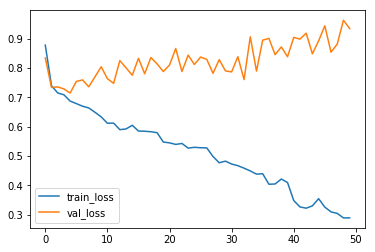

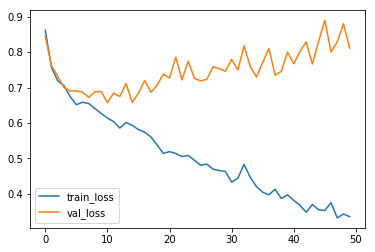

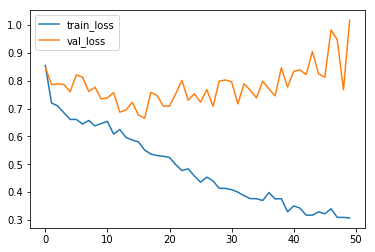

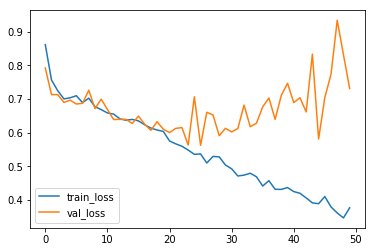

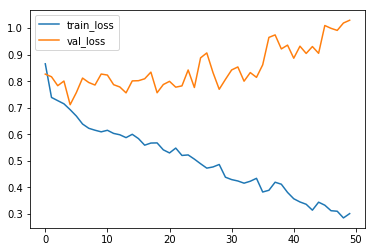

In [8]:
avedloss, avedacc, avevloss, avevacc = 0,0,0,0
my_data = AutoUXDataset(data,labels,True)
my_test = AutoUXDataset(data,labels,False)

batch_size = 64
disable = False
epochs = 50
dropout = 0.5
weight_decay = 0.1
every_other = 1

for i in range(5):
    model = PonceNet(dropout=dropout).cuda()
    optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=2)
    #amp_handle.wrap_optimizer(optimizer)
    criterion = nn.CrossEntropyLoss()
    #amp_handle = amp.init()
    dlosscurve = []
    dacccurve = []
    vlosscurve = []
    vacccurve = []
    print("Fold %d" % (i + 1))
    my_data.setTest(i)
    my_test.setTest(i)
    
    my_loader = DataLoader(my_data, batch_size=batch_size,
                            shuffle=True)
    my_test_loader = DataLoader(my_test, batch_size=batch_size,
                            shuffle=True)
    for j in range(epochs):
        dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
        vloss, vacc = test(model,criterion,scheduler,my_test_loader,disable)
        dlosscurve.append(dloss)
        dacccurve.append(dacc)
        vlosscurve.append(vloss)
        vacccurve.append(vacc)
        if j % every_other == 0:
            print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))
    df = pd.DataFrame(data={"train_loss": dlosscurve, "val_loss": vlosscurve})
    df.plot.line()
    avedloss += dloss
    avedacc += dacc
    avevloss += vloss
    avevacc += vacc
avedloss /= 5
avedacc /= 5
avevloss /= 5
avevacc /= 5
print("Average Train Loss: {:.6f}\nAverage Train Accuracy: {:.6f}\nAverage Test Loss: {:.6f}\nAverage Test Accuracy: {:.6f}\n".format(avedloss,avedacc,avevloss,avevacc))